In [66]:
import pandas as pd
import string
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, ParameterSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

import numpy as np

from nltk.tokenize.casual import TweetTokenizer
tokenizer = TweetTokenizer(reduce_len=True)

# Feature Engineering

In [11]:
# read the raw data and show the data
raw_data = pd.read_csv("./Data/Raw/ExtractedTweets.csv")
raw_data.head()

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...


In [12]:
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

def remove_punctuations(t):
    t = re.sub('@\w+','', t)
    t = "".join([char for char in t if char not in string.punctuation])
    t = re.sub('[0-9]+', '', t)
    return t

def tokenization(t):
    t = re.split('\W+', t)
    return t

def remove_stop_words(t):
    t = [word for word in t if word not in stopword]
    t = [word for word in t if word not in ['rt']]
    return t

def stemming(t):
    t = [ps.stem(word) for word in t]
    return t

In [13]:
def cleaner(t):
    t = remove_punctuations(t).lower()
    t = tokenization(t)
    t = remove_stop_words(t)
    t = stemming(t)
    return t

In [14]:
raw_data['cleaned'] = raw_data.Tweet.apply(lambda x: " ".join(cleaner(x)))
raw_data.head(10)

,Party,Handle,Tweet,cleaned
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",today senat dem vote savetheinternet proud sup...
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,winter resid alta vista teacher one sever reco...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,note hurrican maria left approxim billion dama...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,meet thank take time meet ed marucci guzman na...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,hurrican season start june st puerto rico read...
5,Democrat,RepDarrenSoto,RT @EmgageActionFL: Thank you to all who came ...,thank came orlando gala success night would po...
6,Democrat,RepDarrenSoto,Hurricane Maria left approx $90 billion in dam...,hurrican maria left approx billion damag yet b...
7,Democrat,RepDarrenSoto,RT @Tharryry: I am delighted that @RepDarrenSo...,delight vote cra overrul fcc save netneutr rul...
8,Democrat,RepDarrenSoto,RT @HispanicCaucus: Trump's anti-immigrant pol...,trump antiimmigr polici hurt small busi across...
9,Democrat,RepDarrenSoto,RT @RepStephMurphy: Great joining @WeAreUnidos...,great join roundtabl orlando feder issu affect...


In [15]:
X_train, X_test, y_train, y_test = train_test_split(raw_data.cleaned,raw_data.Party, stratify=raw_data.Party, test_size = 0.2, random_state=123)

# Model Selection

In [16]:
nb_pipleline = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', MultinomialNB())
])

In [12]:
nb_pipleline.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7faa8d8b5470>>)),
                ('classifier', MultinomialNB())])

In [13]:
preds = nb_pipleline.predict(X_test)
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, preds), 4))))

Accuracy: 0.7554


## Gridsearch on naive bayes

In [17]:
%time
nb_params = [{'classifier__alpha': [3,2,1,0.1, 0.01, 0.001, 0.0001, 0.00001]}]
gs = GridSearchCV(estimator=nb_pipleline, param_grid=nb_params, refit=True, cv=4, n_jobs=-1, verbose=10)
gs.fit(X_train, y_train)
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 11 µs
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  13 out of  32 | elapsed:   20.5s remaining:   29.9s
[Parallel(n_jobs=-1)]: Done  17 out of  32 | elapsed:   21.0s remaining:   18.5s
[Parallel(n_jobs=-1)]: Done  21 out of  32 | elapsed:   21.3s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done  25 out of  32 | elapsed:   27.0s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:   27.4s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   27.5s finished


Best Accuracy: 75.94%
Best Params: {'classifier__alpha': 0.1}


In [6]:
plt.bar(['3','2','1','0.1', '0.01', '0.001', '0.0001', '0.00001'],gs.cv_results_['mean_test_score'],align='center', alpha=0.5 )

NameError: name 'gs' is not defined

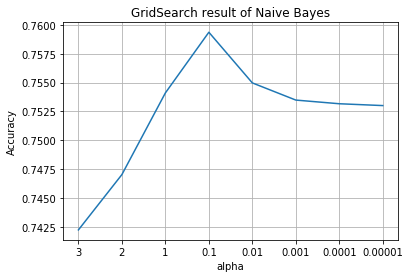

In [18]:
mean_scores_gs = gs.cv_results_['mean_test_score']
C_gs = np.array(['3','2','1','0.1', '0.01', '0.001', '0.0001', '0.00001'])

fig, ax = plt.subplots()
ax.plot(C_gs, mean_scores_gs)

ax.set(xlabel='alpha', ylabel='Accuracy',
       title='GridSearch result of Naive Bayes')
ax.grid()

plt.savefig("NB_gs.png")
plt.show()

In [14]:
nb_pipleline = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', MultinomialNB(alpha=0.1))
])

nb_pipleline.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7faa8d8b5470>>)),
                ('classifier', MultinomialNB(alpha=0.1))])

In [15]:
nb_scores = cross_val_score(nb_pipleline, X_train, y_train, cv=4, n_jobs=-1)

In [41]:
nb_cv_avg = nb_scores.sum()/4

In [27]:
nb_cv_avg = 0.7593684941013185

## SVM

In [98]:
svm_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', SVC(kernel='linear'))
])

In [ ]:
svm_scores = cross_val_score(svm_pipe, X_train, y_train, cv=4, n_jobs=-1)
svm_scores

In [33]:
svm_cv_avg = svm_scores.sum()/4
svm_cv_avg

0.7642840619939857

In [29]:
svm_cv_avg = 0.7642840619939857

In [55]:
svm_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7faa8d8b5470>>)),
                ('classifier', SVC())])

### Gridsearch on SVM
We will use linear kernal in this case, the only hyperparameter that we care is c

In [100]:
svm_params = [{'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}]
gs_svm_linear = GridSearchCV(estimator=svm_pipe, param_grid=svm_params, refit=True, cv=4, n_jobs=-1)
gs_svm_linear.fit(X_train, y_train)

NameError: name 'gs' is not defined

In [101]:
print('Best Accuracy: %.2f%%' % (gs_svm_linear.best_score_*100))
print('Best Params:', gs_svm_linear.best_params_)

Best Accuracy: 75.55%
Best Params: {'classifier__C': 1}


In [105]:
gs_svm_linear.cv_results_

{'mean_fit_time': array([ 764.9028638 ,  758.13181806,  741.95847076,  652.16607904,
        1090.23457623, 3490.57218248]),
 'std_fit_time': array([ 0.48240538,  1.10489355,  0.69683284, 12.22376535, 58.2563761 ,
        24.42130699]),
 'mean_score_time': array([153.45407653, 152.22606462, 151.425493  , 122.28367418,
         79.53728074,  62.32741499]),
 'std_score_time': array([0.68446518, 0.16284618, 0.55434499, 1.43942263, 1.73535659,
        3.55256043]),
 'param_classifier__C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classifier__C': 0.0001},
  {'classifier__C': 0.001},
  {'classifier__C': 0.01},
  {'classifier__C': 0.1},
  {'classifier__C': 1},
  {'classifier__C': 10}],
 'split0_test_score': array([0.51341661, 0.51341661, 0.56263012, 0.7253065 , 0.75693963,
        0.74728198]),
 'split1_test_score': array([0.51341661, 0.51341661, 0.563786

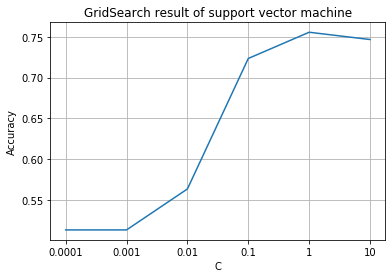

In [7]:
mean_scores_gs = np.array([0.51344552, 0.51344552, 0.56361323, 0.7233981 , 0.75552279, 0.74660248])
C_gs = np.array(['0.0001', '0.001', '0.01', '0.1', '1', '10'])

fig, ax = plt.subplots()
ax.plot(C_gs, mean_scores_gs)

ax.set(xlabel='C', ylabel='Accuracy',
       title='GridSearch result of support vector machine')
ax.grid()

plt.savefig('SVM_GS.png')
plt.show()

## Randomnized search on XGBoost

In [50]:
import scipy.stats

d = {'classifier__max_depth':[5,6,7,8,9,10],
     'classifier__min_child_weight': scipy.stats.uniform(loc=0, scale=10),
     'classifier__eta': scipy.stats.uniform(loc=0, scale=2)}

In [51]:
xgb_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.2, nthreads=-1))
])

rs = RandomizedSearchCV(estimator=xgb_pipe, param_distributions=d, n_iter=10, cv=4, refit=True, random_state=123, n_jobs=-1)

In [53]:
xgb_pipe.fit(X_train, y_train)
xgb_preds = xgb_pipe.predict(X_test)

In [23]:
xgb_pipe_best = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', XGBClassifier(max_depth=9, n_estimators=300, learning_rate=1.06, min_child_weight=4.27, nthreads=-1))
])

xgb_pipe_best.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7faa8d8b5470>>)),
                ('classifier',
                 XGBClassifier(learning_rate=1.06, max_depth=9,
                               min_child_weight=4.27, n_estimators=300,
                               nthreads=-1))])

In [26]:
xgb_pipe_best = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', XGBClassifier(max_depth=9, n_estimators=300, learning_rate=1.06, min_child_weight=4.27, nthreads=-1))
])

xgb_pipe_best.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7faa8d8b5470>>)),
                ('classifier',
                 XGBClassifier(learning_rate=1.06, max_depth=9,
                               min_child_weight=4.27, n_estimators=300,
                               nthreads=-1))])

In [22]:
xgb_pipe_best_1 = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', XGBClassifier(max_depth=10, n_estimators=200, learning_rate=1.06, min_child_weight=4.27, nthreads=-1))
])

In [24]:
%time
xgb_pipe_best_1.fit(X_train, y_train)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7f8bd6e592e8>>)),
                ('classifier',
                 XGBClassifier(learning_rate=1.06, max_depth=10,
                               min_child_weight=4.27, n_estimators=200,
                               nthreads=-1))])

In [25]:
xgb_best_1_preds = xgb_pipe_best_1.predict(X_test)

In [26]:
accuracy_score(xgb_best_1_preds, y_test)

0.7006708304418228

In [107]:
svm_scores_1 = cross_val_score(xgb_pipe_best_1, X_train, y_train, cv=4, n_jobs=-1)
xgb_cv_avg_1 = xgb_scores.sum()/4

KeyboardInterrupt: 

In [28]:
xgb_cv_avg_1 = 0.7006708304418228

In [21]:
xgb_scores = cross_val_score(xgb_pipe_best, X_train, y_train, cv=4, n_jobs=-1, verbose=10)

NameError: name 'xgb_pipe_best' is not defined

In [36]:
xgb_cv_avg = xgb_scores.sum()/4

In [37]:
xgb_cv_avg

0.6887288919731668

In [58]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


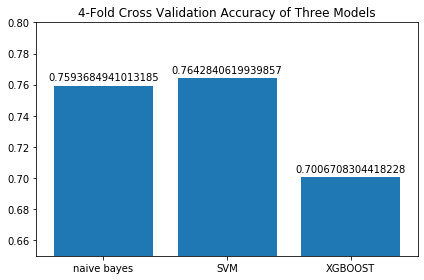

<Figure size 432x288 with 0 Axes>

In [60]:
model_names = np.array(['naive bayes', 'SVM', 'XGBOOST'])
model_test_acc = np.array([nb_cv_avg, svm_cv_avg, xgb_cv_avg_1])
fig, ax = plt.subplots()
rect = ax.bar(model_names, model_test_acc)
plt.ylim([0.65,0.8])
autolabel(rect)
plt.title("4-Fold Cross Validation Accuracy of Three Models")
fig.tight_layout()

plt.show()
plt.savefig('CV_ALL.png')

From this plot we can see that both naive bayes and SVM perform a noticeble better amount than xgboost

## Model Evaluation

Since we already selected the following models:
    1. svm
    2. multinomial naive bayes
    3. XGBoost
    4. Decision Tree

In [64]:
%time
nb_pred = nb_pipleline.predict(X_test)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


NotFittedError: The TF-IDF vectorizer is not fitted

In [95]:
%time
svm_pred = svm_pipe.predict(X_test)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


In [59]:
xgb_pred = xgb_pipe_best.predict(X_test)

In [61]:
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, nb_pred), 4))))
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, svm_pred), 4))))
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, xgb_pred), 4))))

Accuracy: 0.7569
Accuracy: 0.7642
Accuracy: 0.7002


In [63]:
nb_test_score = round(accuracy_score(y_test, nb_pred), 2)
svm_test_score = round(accuracy_score(y_test, svm_pred), 2)
xgb_test_score = round(accuracy_score(y_test, xgb_pred), 2)

NameError: name 'nb_pred' is not defined

In [62]:
labels = ['Naive Bayes', 'SVM', 'XGBoost']
cv_scores = [round(nb_cv_avg,2), round(svm_cv_avg,2), round(xgb_cv_avg_1,2)]
test_scores = [nb_test_score, svm_test_score, xgb_test_score]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cv_scores, width, label='cross validation')
rects2 = ax.bar(x + width/2, test_scores, width, label='test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Different Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.ylim(0.6,0.8)

autolabel(rects1)
autolabel(rects2)

fig.set_figheight(8)
fig.tight_layout()

plt.show()

NameError: name 'nb_test_score' is not defined

# Random Forest

In [69]:
RF_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', RandomForestClassifier(n_jobs=-1, verbose = 10))
])

In [70]:
RF_pipe.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100
building tree 2 of 100building tree 3 of 100

building tree 4 of 100building tree 5 of 100

building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.3s


building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.8s


building tree 21 of 100
building tree 22 of 100building tree 23 of 100

building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   27.5s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100building tree 43 of 100



[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   40.5s


building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   53.5s


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   55.1s


building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100building tree 66 of 100

building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.3min


building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100building tree 88 of 100



[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.6min


building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed:  1.8min remaining:   14.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7f8bc3853358>>)),
                ('classifier', RandomForestClassifier(n_jobs=-1, verbose=10))])

In [72]:
RF_scores = cross_val_score(RF_pipe, X_train, y_train, cv=4, n_jobs=-1)

In [73]:
RF_scores.sum()/4

0.7278221142724959

# Model Comparision
Naive Bayes vs SVM

In [83]:
from sklearn.metrics.cluster import contingency_matrix

In [84]:
svm_cm = confusion_matrix(svm_pred, nb_pred)

In [85]:
svm_cm

array([[6647, 1297],
       [1167, 8181]])

In [87]:
from statsmodels.stats.contingency_tables import mcnemar
result_mcnemar = mcnemar(svm_cm, exact=True)
print('statistic=%.3f, p-value=%.3f' % (result_mcnemar.statistic, result_mcnemar.pvalue))
alpha = 0.05
if result_mcnemar.pvalue > alpha:
    print('Same proportions of errors (fail to reject H0)')
else:
    print('Different proportions of errors (reject H0)')

statistic=1167.000, p-value=0.009
Different proportions of errors (reject H0)


# Discussion
CV vs. .632+, for complicated model (large number of features), should we use cross-validation or .632+?

We will test all three of our models to see the result of 0.632,0.632+, cv and test result.